## Performing SVM based on Twitter.CSV. TFIDF used as tokenizer

Dataset Preview:
                                              tweets  label
0  when modi promised “minimum government maximum...     -1
1  talk all the nonsense and continue all the dra...      0
2  what did just say vote for modi  welcome bjp t...      1
3  asking his supporters prefix chowkidar their n...      1
4  answer who among these the most powerful world...      1

Columns in dataset: Index(['tweets', 'label'], dtype='object')

Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.86      0.89      7102
           0       0.95      0.98      0.96     11043
           1       0.94      0.95      0.94     14451

    accuracy                           0.94     32596
   macro avg       0.94      0.93      0.93     32596
weighted avg       0.94      0.94      0.94     32596



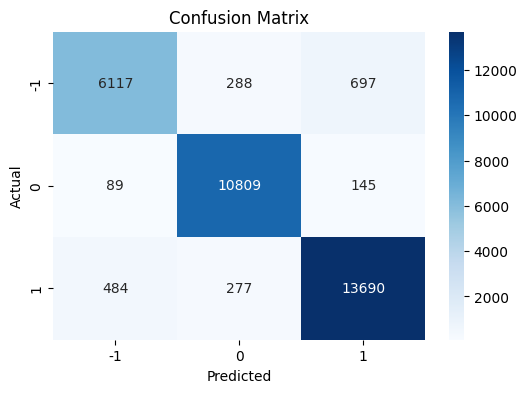

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
file_path = "Twitter_Data.csv"
df = pd.read_csv(file_path)

# Display dataset info
print("Dataset Preview:")
print(df.head())

# Check dataset columns
print("\nColumns in dataset:", df.columns)

# Column names based on dataset
text_column = "tweets"
label_column = "label"

# Drop missing values
df.dropna(subset=[text_column, label_column], inplace=True)

# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = text.strip()
    return text

df[text_column] = df[text_column].astype(str).apply(preprocess_text)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[text_column], df[label_column], test_size=0.2, random_state=42, stratify=df[label_column]
)

# Convert text data to numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features for efficiency
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM model
svm_model = SVC(kernel='linear', C=1.0)  # Linear kernel for text classification
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = svm_model.predict(X_test_tfidf)

# Model evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [2]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.93%


## Getting the model and tokenizer

In [3]:
import pickle

# Save the TF-IDF Vectorizer as a .pkl file
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Save the trained XGBoost model as a .pkl file
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)


## Using the model and tokenizer to predict the preprocessed_tweets.csv and add a seprate column to it

In [4]:
import pandas as pd
import pickle

# Load the preprocessed tweets
file_path = "preprocessed_tweets.csv"
df_new = pd.read_csv(file_path)

# Display dataset preview
print("New Dataset Preview:")
print(df_new.head())

# Check column names
print("\nColumns in new dataset:", df_new.columns)

# Assuming the column containing the tweets is named "tweets"
text_column = "cleaned_text"

# Load the trained SVM model and TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("svm_model.pkl", "rb") as f:
    svm_model = pickle.load(f)

# Transform the new tweets using the loaded vectorizer
X_new_tfidf = vectorizer.transform(df_new[text_column].astype(str))

# Predict sentiment using the trained SVM model
predictions = svm_model.predict(X_new_tfidf)

# Add predictions as a new column
df_new["sentiments"] = predictions

# Save the updated DataFrame to a new CSV file
output_path = "predicted_tweets.csv"
df_new.to_csv(output_path, index=False)

print(f"\nPredictions saved to {output_path}")
print(df_new.head())


New Dataset Preview:
                                                Text  \
0  Excited to have Larry Ellison &amp; Kathleen W...   
1  When one of the interns working on the simulat...   
2                           @5AllanLeVito Got it 😀🇺🇦   
3  Yes. Supercharger coverage will extend to 100%...   
4                     @demishassabis Congratulations   

                                        cleaned_text  
0  excited larry ellison amp kathleen wilsonthomp...  
1          one interns working simulation drops ball  
2                                                got  
3  yes supercharger coverage extend europe next y...  
4                                    congratulations  

Columns in new dataset: Index(['Text', 'cleaned_text'], dtype='object')

Predictions saved to predicted_tweets.csv
                                                Text  \
0  Excited to have Larry Ellison &amp; Kathleen W...   
1  When one of the interns working on the simulat...   
2                           